In this notebook, I evaluate the gradient expressions we use for Metropolis-Hastings. Specifically, I want to understand how good/bad the approximation we use for the reject case is. Let me present the gradient expressions we use first (see the manuscript for details)
$$
\nabla_{\theta} \log P_{\theta}(x'| x) = \begin{cases}
        \nabla_{\theta} \log q_{\theta}(x'|x) & \text{accept} \wedge a_{\theta}(x \to x') = 1 \\
        \nabla_{\theta} \log q_{\theta}(x|x') & \text{accept} \wedge a_{\theta}(x \to x') < 1 \\
        \nabla_{\theta} \log [q_{\theta}(x_p|x)(1 - a_{\theta}(x \to x_p))] & \text{reject}\,\, (x'=x) \\
    \end{cases}
$$
Here, $x_p$ is the proposed (but ultimately rejected) state for sample $x$.

I'll do the evaluation on a simple problem: sampling from a unit 1D Gaussian with a Gaussian proposal with a state-dependent mean.

In [65]:
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

def p(x):
    return st.norm.pdf(x)

def q(x, xp, params):
    """
    Proposal probability q(xp|x)
    """
    w = params
    m = x + w*x
    return st.norm.pdf(xp, loc=m, scale=1.0)

def grad_q(x, xp, params):
    """
    Derivative of proposal probability q(xp|x)
    """
    w = params
    m = x + w*x
    return q(x, xp, params) * (xp - m) * x

def a(x, xp, params):
    """
    Acceptance ratio a(x -> xp) (not rectified to be <= 1.0)
    """
    a = (p(xp) * q(xp, x, params)) / (p(x) * q(x, xp, params))
    return a

def accept_prob(x, xp, params):
    """
    Acceptance probability of x -> xp = min(1, a(x -> xp))
    """
    ar = a(x, xp, params)
    if ar > 1.0:
        ar = 1.0
    return ar
    
def grad_log_pt(x, xp, params):
    """
    Derivative of log T(x -> xp) when xp \neq x
    """
    if a(x, xp, params) > 1.0:
        return grad_q(x, xp, params) / q(x, xp, params)
    else:
        return grad_q(xp, x, params) / q(xp, x, params)
    
def grad_log_pt_diff(x, xp, params, eps=1e-6):
    """
    Finite difference derivative of log T(x -> xp) when xp \neq x
    """
    pt = np.log(q(x, xp, params) * accept_prob(x, xp, params))
    params += eps
    pt_dp = np.log(q(x, xp, params) * accept_prob(x, xp, params))
    return (pt_dp - pt) / eps

First, I will look at the accept case. The expressions here are exact, and our gradient expressions should give values close to the one estimated using finite differences. Below, we generate random pairs of $(x, x')$ and calculate the gradient of $\log P_{\theta}(x'|x)$ using our method and the finite difference method.

<IPython.core.display.Javascript object>


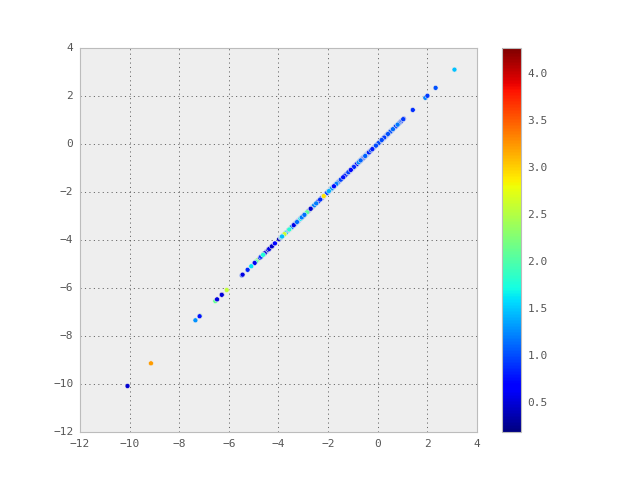

In [11]:
params = -0.5
N = 1000
g_diff = np.zeros(N)
g_our = np.zeros(N)
ars = np.zeros(N)
x = np.random.randn(N)
xp = np.random.randn(N)
for i in range(N):
    g_diff[i] = grad_log_pt_diff(x[i], xp[i], params)
    g_our[i] = grad_log_pt(x[i], xp[i], params)
    ars[i] = a(x[i], xp[i], params)
plt.scatter(g_diff, g_our, c=ars)
plt.colorbar()

As we see, estimates from both methods lie on the $x=y$ line, i.e., they are equal.

Now, let us look at the reject case.

The above expression for the gradient in the reject case is (obviously) wrong. I have been using that in my simulations so far, and it is maybe no surprise that our method did not really work on any problem other than the toy 1D Gaussian example. Here, let us derive less wrong approximations to the gradient in the reject case. We would like to estimate $\nabla_{\theta} \log P_{\theta}(x'|x)$ where $x'=x$ because the proposed move at $x$ is rejected. We know
$$
P_{\theta}(x'|x) = \int q_{\theta}(y|x) (1 - a_{\theta}(x\to y)) dy
$$

**Method 1** Do a Monte Carlo approximation to $P(x'|x)$ and then take its derivative.
$$
P_{\theta}(x'|x) \approx \sum_{y \sim q} (1 - a_{\theta}(x\to y))
$$
and
$$
\nabla_{\theta} \log P_{\theta}(x'|x) \approx \nabla_{\theta} \log \sum_{y \sim q} (1 - a_{\theta}(x\to y))
$$
finally
$$
\nabla_{\theta} \log P_{\theta}(x'|x) \approx \frac{\sum_{y \sim q} \nabla_{\theta} (1 - a_{\theta}(x\to y))}{\sum_{y \sim q} (1 - a_{\theta}(x\to y)}
$$
If we use a single $y$ sample, we get (method 1)
$$
\nabla_{\theta} \log P_{\theta}(x'|x) \approx \frac{\nabla_{\theta} (1 - a_{\theta}(x\to y))}{(1 - a_{\theta}(x\to y)}
$$
We took a few questionable steps here. We took the derivative of a Monte Carlo approximation. However, I don't know whether the derivative of a Monte Carlo approximation to a function is equal to the derivative of that function. Are there cases where this is not true and what are the convergence properties of such an approximation? 

**Method 2** Now, first take the derivative and then replace values with their Monte Carlo approximations.
$$
\nabla_{\theta} \log P_{\theta}(x'|x) = \frac{\nabla_{\theta} P_{\theta}(x'|x)}{P_{\theta}(x'|x)} 
$$
Push the derivative inside the integral for $P(x'|x)$ and after some manipulation, we get the following Monte Carlo approximation
$$
\nabla_{\theta} P_{\theta}(x'|x) \approx \sum_{y \sim q} (1 - a_{\theta}(x\to y)) \nabla_{\theta} \log q_{\theta}(y|x) + \nabla_{\theta} (1 - a_{\theta}(x\to y))
$$
We can replace the denominator with its Monte Carlo approximation as well to get 
$$
\nabla_{\theta} \log P_{\theta}(x'|x) \approx \frac{\sum_{y \sim q} (1 - a_{\theta}(x\to y)) \nabla_{\theta} \log q_{\theta}(y|x) + \nabla_{\theta} (1 - a_{\theta}(x\to y))}{\sum_{y \sim q} (1 - a_{\theta}(x\to y))}
$$
If we use a single $y$ sample, we get (method 2)
$$
\nabla_{\theta} \log P_{\theta}(x'|x) \approx \frac{(1 - a_{\theta}(x\to y)) \nabla_{\theta} \log q_{\theta}(y|x) + \nabla_{\theta} (1 - a_{\theta}(x\to y))}{(1 - a_{\theta}(x\to y))}
$$

**Method 3** Another idea is to lower bound $\log P_{\theta}(x'|x)$ using Jensen's inequality and take the derivative. However, this would be useless since $f(x) > g(x)$ for all $x$ does not imply $f'(x) > g'(x)$. In any case, I still calculate this approximation below and compare it to other two.

In [84]:
def grad_log_pt_reject(x, params, eps=1e-6, n=500):
    w = params
    m = x + w*x
    e = st.norm.rvs(size=n)
    ys = m + e
    pt = np.log(np.mean([1 - accept_prob(x, y, params) for y in ys]))
    
    params += eps
    w = params
    m = x + w*x
    ys = m + e
    pt_dp = np.log(np.mean([1 - accept_prob(x, y, params) for y in ys]))
    
    # finite difference method
    grad_diff = (pt_dp - pt) / eps
    
    # our method (1)
    def fn1(y):
        if a(x, y, params) < 1.0:
            return ((-p(y)/p(x)) * ((grad_q(y, x, params) * q(x, y, params)) - (q(y, x, params) * grad_q(x, y, params))) / q(x, y, params)**2), (1.0 - a(x, y, params))
        else:
            return 0.0, 0.0
    grad_our = np.array([fn1(y) for y in ys])
    
    def fn2(y):
        if a(x, y, params) < 1.0:
            return ((1.0 - a(x, y, params)) * grad_q(x, y, params) / q(x, y, params)) + ((-p(y)/p(x)) * ((grad_q(y, x, params) * q(x, y, params)) - (q(y, x, params) * grad_q(x, y, params))) / q(x, y, params)**2), (1.0 - a(x, y, params))
        return 0.0, 0.0
    grad_our2 = np.array([fn2(y) for y in ys])
    
    def fn3(y):
        if a(x, y, params) < 1.0:
            t1 = grad_q(x, y, params) * np.log(1.0 - a(x, y, params)) / q(x, y, params)
            t2 = fn1(y)
            t2 = t2[0] / t2[1]
            return t1 + t2
        else:
            return 0.0
    grad_our3 = np.array([fn3(y) for y in ys])
            
    return grad_diff, grad_our, grad_our2, grad_our3

In [85]:
reps = 20

xs = np.zeros(reps)
ws = np.zeros(reps)
rows = []
for rep in range(reps):
    params = 3 * (np.random.rand() - 0.5)
    x = 2 * (np.random.rand() - 0.5)
    xs[rep] = x
    ws[rep] = params
    
    
    g_diff, g_our, g_our2, g_our3 = grad_log_pt_reject(x, params, n=500)

    # two ways to calculate estimate
    # 1) ignore nans
    s1 = g_our[:, 0] / g_our[:, 1]
    e11 = np.nanmean(s1)
    # 2) treat nans az 0
    s1[np.isnan(s1)] = 0.0
    e12 = np.mean(s1)
    
    e13 = np.mean(g_our[:,0]) / np.mean(g_our[:,1])

    s2 = g_our2[:, 0] / g_our2[:, 1]
    e21 = np.nanmean(s2)
    s2[np.isnan(s2)] = 0.0
    e22 = np.mean(s2)

    e23 = np.mean(g_our2[:,0]) / np.mean(g_our2[:,1])
    
    s3 = g_our3
    e31 = np.mean(s3[np.logical_not(np.isclose(s3, 0.0))])
    e32 = np.mean(s3)
    
    rows.append({'our1_1': e11 - g_diff, 'our1_2': e12 - g_diff, 'our2_1': e21 - g_diff, 
                 'our2_2': e22 - g_diff, 'our3_1': e31 - g_diff, 'our3_2': e32 - g_diff,
                'our1_3': e13 - g_diff, 'our2_3': e23 - g_diff})
    
df = pd.DataFrame(rows)

Are the single sample estimates close to the true value? And which method is better?

our1_1    0.188972
our1_2    1.064015
our1_3    0.197713
our2_1    0.130940
our2_2    0.991488
our2_3    0.023092
our3_1    0.193339
our3_2    1.065377
dtype: float64


<IPython.core.display.Javascript object>


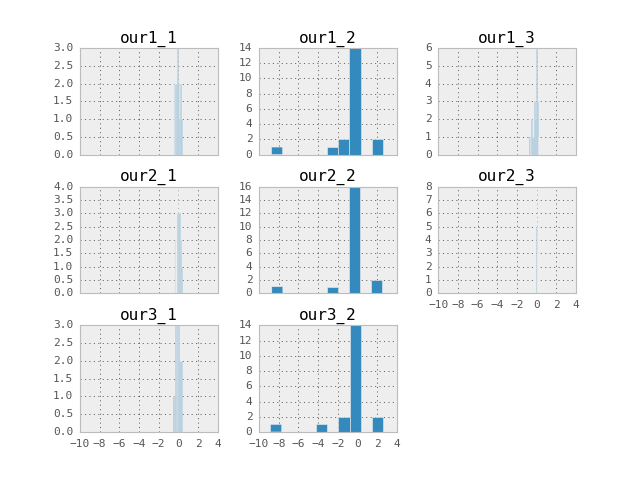

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f335a01e350>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3359c41810>]], dtype=object)

In [86]:
print df.abs().mean()
df.hist(sharex=True)

It looks like method 2 gives the best results!